In [18]:
import numpy as np
import timm
import torch
from torch.autograd import Variable
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from PIL import Image
import matplotlib.pyplot as plt
from scipy.special import softmax

from Cancer import utils

## Load Model with PyTorch

### Cancer

In [2]:
cancer_model = utils.get_model("Cancer", "cpu")
cancer_model.eval()
cancer_data = utils.get_dataset("Cancer/input")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9996777614028511


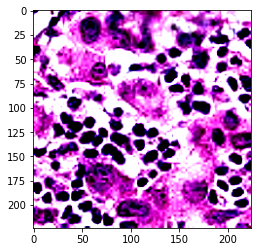

In [3]:
cancer_input = cancer_data[3][0]
plt.imshow(cancer_input.permute(1,2,0))
cancer_input = cancer_input.unsqueeze(0)

import math
sigmoid = lambda x: 1 / (1 + math.exp(-x))

output = cancer_model(cancer_input).detach()
pr = output[:,0].numpy()
print(sigmoid(pr[0]))

### ImageNet

In [4]:
imagenet_model = timm.create_model('convnext_base', pretrained=True)
imagenet_model.eval()

config = resolve_data_config({}, model=imagenet_model)
transform = create_transform(**config)
with open("ImageNet/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

garbage truck 0.9529080986976624
ashcan 0.0007844393840059638
snowplow 0.0002222781622549519
trailer truck 0.00017542162095196545
vulture 0.00012882986629847437


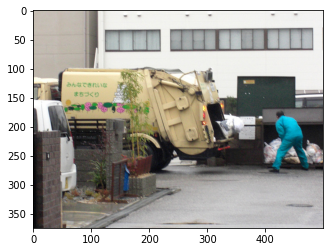

In [5]:
img = Image.open("ImageNet/imagenette2/val/n03417042/n03417042_9511.JPEG").convert('RGB')
plt.imshow(img)

tensor = transform(img).unsqueeze(0) # transform and add batch dimension
tensor.shape

with torch.no_grad():
    out = imagenet_model(tensor)
probabilities = torch.nn.functional.softmax(out[0], dim=0)

# Print top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

## Convert to ONNX Format

In [6]:
dummy_input = Variable(torch.randn(1, 3, 224, 224))

In [7]:
torch.onnx.export(cancer_model, dummy_input, "Cancer/converted_onnx_model.onnx", operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)
torch.onnx.export(imagenet_model, dummy_input, "ImageNet/converted_onnx_model.onnx")

/home/simonliu/.local/lib/python3.8/site-packages/torch/onnx/utils.py:284: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  warnings.warn("`{}' can be set to True only when 'operator_export_type' is "
/home/simonliu/.local/lib/python3.8/site-packages/torch/onnx/utils.py:284: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  warnings.warn("`{}' can be set to True only when 'operator_export_type' is "


## Convert to TF Format

In [8]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX file
cancer_onnx = onnx.load('Cancer/converted_onnx_model.onnx')
imagenet_onnx = onnx.load('ImageNet/converted_onnx_model.onnx')

In [9]:
# Import the ONNX model to Tensorflow
tf_cancer = prepare(cancer_onnx)
tf_imagenet = prepare(imagenet_onnx)

In [10]:
# Export to TF File
# (This doesn't work on my laptop :( )
#tf_cancer.export_graph('Cancer/converted_tf_model.pb')
#tf_imagenet.export_graph('ImageNet/converted_tf_model.pb')

### Cancer Validation

In [15]:
output = tf_cancer.run(np.asarray(cancer_input, dtype=np.float32))
pr = output[0][:,0]
print(sigmoid(pr[0]))

0.9996777614028511


### ImageNet Validation

In [32]:
output = tf_imagenet.run(np.asarray(tensor, dtype=np.float32))
probabilities = softmax(output[0][0])

# Print top categories per image
top5_prob, top5_catid = np.sort(probabilities)[-5:], np.argsort(probabilities)[-5:]
for i in reversed(range(len(top5_prob))):
    print(categories[top5_catid[i]], top5_prob[i].item())

garbage truck 0.9529080986976624
ashcan 0.0007844362989999354
snowplow 0.00022227772569749504
trailer truck 0.00017542176647111773
vulture 0.0001288296189159155
